<a href="https://colab.research.google.com/github/BarAvni/deep_learning_2020/blob/master/Homework_3_point_cloud_mnist_BAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#if youre running on colab, run this line first to properly load the h5 files
!pip install tables --upgrade

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [4]:
#!wget -O training_ds.h5 https://www.dropbox.com/sh/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a?dl=0&preview=training_ds.h5
# !wget -O valid_ds.h5 https://www.dropbox.com/sh/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a?dl=0&preview=valid_ds.h5

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
ds = CustomDataset('/content/drive/My Drive/ML course/training_ds.h5')

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

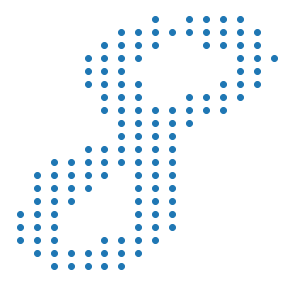

In [7]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

In [8]:
ds.n_points[445]

131

In [9]:
ds.n_points

0       117
1       130
2        88
3        70
4        97
       ... 
9995    120
9996    111
9997    114
9998     81
9999     88
Name: n_points, Length: 10000, dtype: object

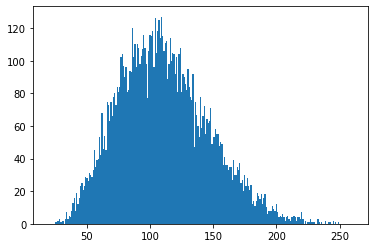

In [10]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [11]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [12]:
batch_size = 50
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
data_loader = DataLoader(ds, batch_sampler=batch_sampler)

In [13]:
for epoch in range(3):
    print(epoch)
    for x,y in data_loader:
        print(x.shape)
    break

0
torch.Size([2, 207, 2])
torch.Size([57, 108, 2])
torch.Size([15, 187, 2])
torch.Size([6, 205, 2])
torch.Size([13, 39, 2])
torch.Size([33, 162, 2])
torch.Size([36, 160, 2])
torch.Size([54, 124, 2])
torch.Size([53, 99, 2])
torch.Size([98, 115, 2])
torch.Size([1, 249, 2])
torch.Size([25, 172, 2])
torch.Size([24, 180, 2])
torch.Size([29, 49, 2])
torch.Size([63, 109, 2])
torch.Size([11, 183, 2])
torch.Size([96, 103, 2])
torch.Size([30, 167, 2])
torch.Size([30, 168, 2])
torch.Size([53, 111, 2])
torch.Size([53, 139, 2])
torch.Size([75, 136, 2])
torch.Size([82, 83, 2])
torch.Size([1, 243, 2])
torch.Size([55, 88, 2])
torch.Size([4, 202, 2])
torch.Size([12, 43, 2])
torch.Size([11, 197, 2])
torch.Size([18, 188, 2])
torch.Size([57, 108, 2])
torch.Size([52, 118, 2])
torch.Size([84, 76, 2])
torch.Size([50, 156, 2])
torch.Size([71, 148, 2])
torch.Size([7, 220, 2])
torch.Size([51, 77, 2])
torch.Size([55, 144, 2])
torch.Size([40, 59, 2])
torch.Size([28, 50, 2])
torch.Size([8, 199, 2])
torch.Size([4, 

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [14]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

linear_layer(  torch.rand((345,10)) ).shape, linear_layer(  torch.rand((345,76,10)) ).shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [15]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape

torch.Size([42, 10])

In [16]:
cov = nn.Conv1d(26, 3, 2) 
cov(  torch.rand((1,26,2)) ).shape

        # self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        # self.conv_2 = nn.Conv1d(64, 128, 1)
        # self.conv_3 = nn.Conv1d(128, 1024, 1)

torch.Size([1, 3, 1])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [17]:
# class DeepSet(nn.Module):
#     def __init__(self, in_dim, n_classes):
#         super(DeepSet, self).__init__()
#         self.layer1 = nn.Linear(in_dim, 512)
#         self.layer2 = nn.Linear(512,512)
#         self.layer3 = nn.Linear(512,512)
#         # self.layer4 = nn.Linear(512,264)
#         self.classify = nn.Linear(512, n_classes)

#         self.droput = nn.Dropout(0.2)

#     def forward(self, x):
#         out = F.relu(self.layer1(x))
#         # add dropout layer
#         out = self.droput(out)
#         out = F.relu(self.layer2(out))
#         out = F.relu(self.layer3(out))
#         out = self.droput(out)
#         # out = F.relu(self.layer4(out))
#         # mean operation
#         out = torch.mean(out,dim=1)
#         return F.log_softmax(self.classify(out), dim=1)

       

In [18]:
 class DeepSet(nn.Module):
    def __init__(self, in_dim, n_classes):
        super(DeepSet, self).__init__()
        # self.conv_1 = nn.Conv1d(input_dim, 64, 1) 
        self.fc_1 = nn.Linear(in_dim, 712)
        self.fc_2 = nn.Linear(712, 512)
        self.fc_3 = nn.Linear(512, 512)
        self.fc_4 = nn.Linear(512, 256)
        self.classify = nn.Linear(256, n_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.dropout(x)
        x = F.relu(self.fc_3(x))
        x = F.relu(self.fc_4(x))
        x = self.dropout(x)
        # mean operation
        x = torch.mean(x,dim=1)
        return F.log_softmax(self.classify(x), dim=1)
        

In [19]:
k = len(np.unique(ds.label))
net = DeepSet(2, k)

In [20]:
def compute_accuracy(data_loader,net,criterion):
    
    net.eval()
    
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        
        prediction = net(x.cuda()).cpu().data.numpy()
        loss = criterion(prediction,torch.LongTensor(y).cuda()) # torch.LongTensor(targets) convert the (10000,) to (10000,1)
        print(loss)
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number), loss.item()

In [22]:
test_ds = CustomDataset('/content/drive/My Drive/ML course/valid_ds.h5')
batch_size = 50
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

# compute_accuracy(data_loader_test,net)

In [23]:
import  torch
from torch.utils import data
from tqdm.notebook import tqdm
# Stochastic gradient descent optimaizer with learning rate of 0.01
# import torch.optim as optim
from torch.optim import Adam, SGD
# optimizer = Adam(net.parameters(), lr=0.01)
optimizer = SGD(net.parameters(), lr=0.01) 
# Loss function 
loss_func = nn.CrossEntropyLoss()
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    net.cuda()
# number of epoches to train the model 
n_epochs = 70
# Initialsize tracker for minimum validation loss 
valid_loss_min = np.Inf

loss_vs_epoch = []
accuracy_vs_epoch = []

# Loop over the epochs: 
for epoch in tqdm( range(n_epochs) ):
    ##  Training ## 
    net.train() # prep model for training 
    for x,y in data_loader:
      data, target = x.to(device), torch.LongTensor(y).to(device)
      # Clear the gradients for all optimized variables 
      optimizer.zero_grad()
      # Farward pass: compute predicted outputs ny passing inputs to the model 
      pred = net(data)
      # Loss calculation 
      loss = loss_func(pred,target) # torch.LongTensor(targets) convert the (10000,) to (10000,1)
      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Model weight modification based on the optimizer 
      optimizer.step()
    ## Validation ##       
    net.eval() # evaluation mode - use the function above for each epoch 
    for x,y in data_loader_test:
      data, target = x.to(device), torch.LongTensor(y).to(device)
      # Farward pass: compute predicted outputs ny passing inputs to the model 
      pred = net(data)
      # Loss calculation 
      loss = loss_func(pred,target) # torch.LongTensor(target) convert the (n,) to n,1)
    
    training_accuracy, training_loss = compute_accuracy(data_loader,net, loss_func)
    validation_accuracy, validation_loss = compute_accuracy(data_loader_test,net, loss_func)
    
    print(validation_accuracy)

    loss_vs_epoch.append([training_loss, validation_loss])
    
    accuracy_vs_epoch.append([training_accuracy, validation_accuracy])

    # Save model of Validation loss has decreased
    if validation_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, validation_loss))
      torch.save(net.state_dict(), 'model_rotation.pt')
      valid_loss_min = validation_loss


cuda:0


0.098
0.098
0.098
0.098
0.098
0.098
0.098
0.098
0.098
0.098
0.098
0.1346
0.098
0.098
0.098
0.1464
0.098
0.1509
0.1839
0.1965
0.1995
0.2176
0.1748
0.2326
0.2532
0.247
0.2684
0.2575
0.2903
0.2688
0.2597
0.2534
0.2692
0.2322
0.3064
0.3174
0.3156
0.2945
0.2819
0.1849
0.3353
0.3689
0.3214
0.3483
0.3866
0.3827
0.4041
0.4127
0.4014
0.4863
0.5068
0.429
0.4537
0.3601
0.5658
0.6033
0.5956
0.6191
0.6483
0.63
0.6658
0.6928
0.7117
0.6459
0.7073
0.7299
0.7429
0.674
0.7601
0.7782

